In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [24]:
players = pd.read_csv("car_prices.csv")

In [25]:
players.head()

,car_id,price,fuel type,gear type,Make,Model,Year of manufacture,Colour,Condition,Mileage,Engine Size,Selling Condition,Bought Condition,car,Trim,Drivetrain,Seats,Number of Cylinders,Horse Power,Registered city
0,icwAaDOmX573WiRRnLFPT237,2812500,Petrol,Automatic,Toyota,Corolla,2004,Silver,Nigerian Used,251732.0,1800.0,Registered,Registered,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ByZ3NlPy2x0arAIyrKazClUS,5000000,Petrol,Automatic,Acura,MDX,2007,Green,Foreign Used,224589.0,3700.0,Imported,Imported,SUV,NaN,NaN,NaN,NaN,NaN,NaN
2,2zG6Mh3kwyoTvWoeKHkV1oFH,7592000,Petrol,Automatic,Acura,TL,2012,White,Foreign Used,111334.0,3500.0,Imported,Imported,Sedan,SH-AWD Automatic Tech Package,All Wheel,5.0,6.0,309.0,NaN
3,7APLHOPlI93qsYK0ST4D4wB2,9880000,Petrol,Automatic,Land Rover,Range Rover,2012,Gray,Nigerian Used,72682.0,4000.0,Registered,Imported,SUV,NaN,NaN,NaN,NaN,NaN,NaN
4,zIrIDPJLd46eRQf9JFacc0e,4160000,Petrol,Automatic,Ford,Edge,2013,Gray,Nigerian Used,92118.0,3500.0,Registered,Registered,SUV,NaN,NaN,NaN,NaN,NaN,Lagos


In [26]:
features = ["price","Mileage"]

In [27]:
players = players.dropna(subset=features)

In [28]:
data = players[features].copy()

In [29]:
data

,price,Mileage
0,2812500,251732.0
1,5000000,224589.0
2,7592000,111334.0
3,9880000,72682.0
4,4160000,92118.0
...,...,...
3717,1924000,282769.0
3718,1890000,182544.0
3719,1155000,234354.0
3720,1260000,345926.0


In [30]:
data = ((data-data.min())/(data.max()-data.min()))*9+1

In [31]:
data.describe()

,price,Mileage
count,3663.000000,3663.000000
mean,1.580019,1.714423
std,0.627738,0.511408
min,1.000000,1.000000
25%,1.265380,1.430132
50%,1.408892,1.645927
75%,1.653355,1.899080
max,10.000000,10.000000


In [32]:
data.head()

,price,Mileage
0,1.329224,1.922348
1,1.647534,1.822895
2,2.024705,1.407927
3,2.357639,1.266305
4,1.525303,1.337519


KMeans

In [33]:
def random_centroids(data, k):
    centroids=[]
    for i in range(k):
        centroid =data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [34]:
centroids = random_centroids(data,2)

In [35]:
print(centroids)

                0         1
price    1.313436  1.752304
Mileage  2.038794  1.624807


In [36]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data-x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [37]:
labels = get_labels(data,centroids)

In [38]:
labels.value_counts()

1    2065
0    1598
dtype: int64

In [39]:
def new_cenroids(data, labels, k):
    data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

In [40]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components = 2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteraion{iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:1])
    plt.show()

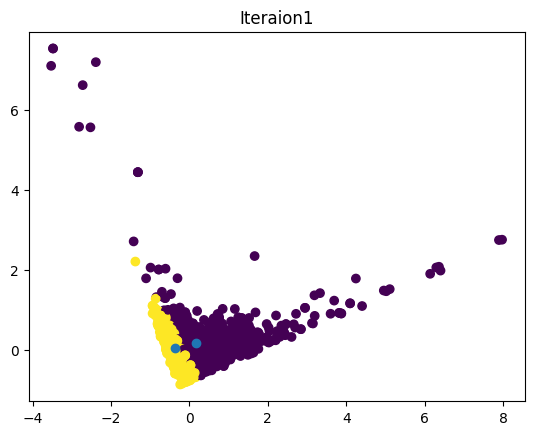

In [41]:
max_iterations = 100
k = 2

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(data, centroids)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

DBScan

In [65]:
db = DBSCAN(eps = 3, min_samples = 10).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [66]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

In [55]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

InvalidIndexError: (slice(None, None, None), 0)